In [1]:
import numpy as np
from pointcloud.config_varients.wish import Configs
from pointcloud.data import trees
from pointcloud.anomalies.detect import detect, save_path_for_model
from matplotlib import pyplot as plt
from IPython.display import display_markdown
import matplotlib
import os
config = Configs()
matplotlib.rcParams['figure.figsize'] = 5, 5

model_path = "/home/dayhallh/training/point-cloud-diffusion-logs/anomalies/24-05-27.23_13496.pt"
scores_path = save_path_for_model(model_path)

recalc_scores = False
if not os.path.exists(scores_path) or recalc_scores:
    detect(model_path, config)
scores = np.load(scores_path)

dat = trees.DataAsTrees(config)
plot_args = {"xlims":(-150, 150), "ylims":(-200, 100), "zlims":(-2, 32)}



# displaying trees

Just show a single tree to check the axis ranges.
Also, define the ability to make a double plot and show it.

In [2]:
plot_num = 0

plots_folder = os.path.join(config.image_dir, "anomaly_nb")
if not os.path.exists(plots_folder):
    os.mkdir(plots_folder)
def make_double(i):
    plt.close()
    score = scores[i, 1]
    points_only = os.path.join(plots_folder, f"points_evt{i}.jpg")
    points_only = f"points_evt{i}.jpg"
    fig, ax = trees.plot_tree(dat, i, line_alpha=0, show=False, **plot_args)
    ax.set_title(f"Event {i}, Anomaly score {score:.4g}")
    plt.tight_layout()
    plt.savefig(points_only)
    plt.close()
    with_lines = os.path.join(plots_folder, f"lines_evt{i}.jpg")
    with_lines = f"lines_evt{i}.jpg"
    fig, ax = trees.plot_tree(dat, i, line_alpha=0.6, show=False, **plot_args)
    ax.set_title(f"Event {i}, Anomaly score {score:.4g}")
    plt.tight_layout()
    plt.savefig(with_lines)
    plt.close()
    return f"![Points]({points_only})  ![Lines]({with_lines})"
    

display_markdown(make_double(0), raw=True)

![Points](points_evt0.jpg)  ![Lines](lines_evt0.jpg)

Text(0, 0.5, 'N showers')

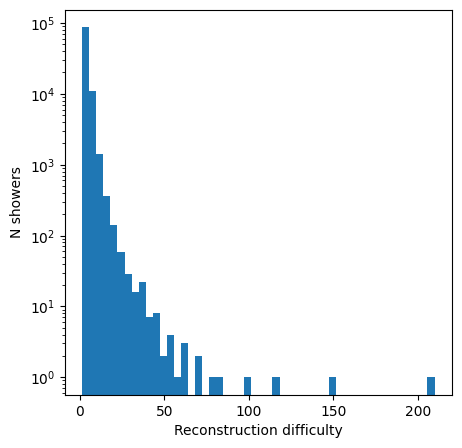

In [3]:
from matplotlib import pyplot as plt
hist = plt.hist(scores[:, 1], bins=50)
plt.semilogy()
plt.xlabel("Reconstruction difficulty")
plt.ylabel("N showers")

In [4]:
high_anomaly = np.argsort(scores[:, 1])[-10:]
low_anomaly = np.argsort(scores[:, 1])[:10]
print((high_anomaly, low_anomaly))

(array([62490, 47947, 18781, 91198, 74693, 12174, 25107, 90300, 23331,
        1283]), array([98333, 66350, 39691, 40410, 87763, 43904, 81460, 73397, 51356,
       19021]))


In [5]:
for i in high_anomaly:
    display_markdown(make_double(i), raw=True)

![Points](points_evt62490.jpg)  ![Lines](lines_evt62490.jpg)

![Points](points_evt47947.jpg)  ![Lines](lines_evt47947.jpg)

![Points](points_evt18781.jpg)  ![Lines](lines_evt18781.jpg)

![Points](points_evt91198.jpg)  ![Lines](lines_evt91198.jpg)

![Points](points_evt74693.jpg)  ![Lines](lines_evt74693.jpg)

![Points](points_evt12174.jpg)  ![Lines](lines_evt12174.jpg)

![Points](points_evt25107.jpg)  ![Lines](lines_evt25107.jpg)

![Points](points_evt90300.jpg)  ![Lines](lines_evt90300.jpg)

![Points](points_evt23331.jpg)  ![Lines](lines_evt23331.jpg)

![Points](points_evt1283.jpg)  ![Lines](lines_evt1283.jpg)

In [6]:
for i in low_anomaly:
    display_markdown(make_double(i), raw=True)

![Points](points_evt98333.jpg)  ![Lines](lines_evt98333.jpg)

![Points](points_evt66350.jpg)  ![Lines](lines_evt66350.jpg)

![Points](points_evt39691.jpg)  ![Lines](lines_evt39691.jpg)

![Points](points_evt40410.jpg)  ![Lines](lines_evt40410.jpg)

![Points](points_evt87763.jpg)  ![Lines](lines_evt87763.jpg)

![Points](points_evt43904.jpg)  ![Lines](lines_evt43904.jpg)

![Points](points_evt81460.jpg)  ![Lines](lines_evt81460.jpg)

![Points](points_evt73397.jpg)  ![Lines](lines_evt73397.jpg)

![Points](points_evt51356.jpg)  ![Lines](lines_evt51356.jpg)

![Points](points_evt19021.jpg)  ![Lines](lines_evt19021.jpg)

In [7]:
from pointcloud.data.read_write import read_raw_regaxes
pick_events = np.arange(5000)

incidents, events = read_raw_regaxes(config, pick_events=pick_events)


In [8]:

xs = np.linspace(10, 90, 50)
c_hits = 190
m_hits = 35
ys_hits = xs*m_hits + c_hits
c_energy = 0
m_energy = 0.015
ys_energy = xs*m_energy + c_energy


In [9]:
import plotly.express as px
from plotly.subplots import make_subplots
import numpy as np
import pandas as pd
sum_data = {"incident energy": incidents, "idx": list(range(len(incidents)))}

#energy
energies = events[:, :, 3]

sum_data["energy"] = np.sum(energies[:, :], axis=1)

# hits
sum_data["hits"] = np.sum(energies[:, :]>0, axis=1)

event_scores = np.log(scores[pick_events][:, 1])
sum_data["anomaly_score"] = event_scores/np.max(event_scores) -0.5

for k in sum_data:
    print((k, len(sum_data[k])))

sum_dataframe = pd.DataFrame(data=sum_data)

fig = make_subplots(rows=1, cols=2) 
fig.update_layout(plot_bgcolor = "black")
sub_fig_e = px.scatter(sum_dataframe, x="incident energy", y=["energy", "energy"],
                       color="anomaly_score", #"idx",
                          color_continuous_scale=px.colors.diverging.balance,
                       opacity=0.8)
sub_fig_hits = px.scatter(sum_dataframe, x="incident energy", y=["hits", "hits"],
                          color="anomaly_score",
                          color_continuous_scale=px.colors.sequential.Blackbody,
                          opacity=0.8)

sub_fig_e.add_scatter(x=xs, y=ys_energy, fillcolor='red', name="cutoff")
sub_fig_hits.add_scatter(x=xs, y=ys_hits, fillcolor='red', name="cutoff")
# add each trace (or traces) to its specific subplot
for i in sub_fig_e.data :
    fig.add_trace(i, row=1, col=1)

for i in sub_fig_hits.data :    
    fig.add_trace(i, row=1, col=2)
fig['layout']['xaxis']['title']='Incident energy'
fig['layout']['yaxis']['title']='Observed energy'
fig['layout']['xaxis2']['title']='Incident energy'
fig['layout']['yaxis2']['title']='Observed hits'

('incident energy', 5000)
('idx', 5000)
('energy', 5000)
('hits', 5000)
('anomaly_score', 5000)


In [10]:
import plotly.io as pio
pio.renderers.default = 'iframe'

fig.show()

In [11]:
down=1.
below_hits = sum_data["hits"] < (incidents*m_hits + c_hits)*down
below_hits = np.where(below_hits)[0]
print(below_hits)
below_energy = sum_data["energy"] < (incidents*m_energy + c_energy)*down
below_energy = np.where(below_energy)[0]
print(below_energy)

below_both = [i for i in below_hits if i in below_energy]
only_e = [i for i in below_energy if i not in below_hits]
print(only_e)
only_h = [i for i in below_hits if i not in below_energy]
print(only_h)

[ 267  287  701 1174 1283 1718 1750 1946 2033 2288 3565 3659 3725 3775
 4108 4341]
[ 267  287  701 1718 1750 2033 2288 3565 3659 3775 4108 4248 4341]
[4248]
[1174, 1283, 1946, 3725]


In [12]:
for i in below_both:
    display_markdown(make_double(i), raw=True)

![Points](points_evt267.jpg)  ![Lines](lines_evt267.jpg)

![Points](points_evt287.jpg)  ![Lines](lines_evt287.jpg)

![Points](points_evt701.jpg)  ![Lines](lines_evt701.jpg)

![Points](points_evt1718.jpg)  ![Lines](lines_evt1718.jpg)

![Points](points_evt1750.jpg)  ![Lines](lines_evt1750.jpg)

![Points](points_evt2033.jpg)  ![Lines](lines_evt2033.jpg)

![Points](points_evt2288.jpg)  ![Lines](lines_evt2288.jpg)

![Points](points_evt3565.jpg)  ![Lines](lines_evt3565.jpg)

![Points](points_evt3659.jpg)  ![Lines](lines_evt3659.jpg)

![Points](points_evt3775.jpg)  ![Lines](lines_evt3775.jpg)

![Points](points_evt4108.jpg)  ![Lines](lines_evt4108.jpg)

![Points](points_evt4341.jpg)  ![Lines](lines_evt4341.jpg)

In [13]:
for i in only_e:
    display_markdown(make_double(i), raw=True)

![Points](points_evt4248.jpg)  ![Lines](lines_evt4248.jpg)

In [14]:
for i in only_h:
    display_markdown(make_double(i), raw=True)

![Points](points_evt1174.jpg)  ![Lines](lines_evt1174.jpg)

![Points](points_evt1283.jpg)  ![Lines](lines_evt1283.jpg)

![Points](points_evt1946.jpg)  ![Lines](lines_evt1946.jpg)

![Points](points_evt3725.jpg)  ![Lines](lines_evt3725.jpg)

## MC particles

Now we look at the MC particles, and see how the rares corrispond to anomaly scores.

In [15]:
from particle import Particle
mc_data_file = "/home/dayhallh/Data/p22_th90_ph90_en10-100_MCParticles.npz"
data = np.load(mc_data_file)
indices = data["idx"]
pdg = data["PDG"]
pdg.shape

(110000, 73)

In [16]:
set_pdg = sorted(set(pdg.flatten()))
set_abs = sorted(set(np.abs(pdg.flatten())))
print(f"The number of PDG id's in the data is {len(set_pdg)}, and if we ignore the difference between particle and antiparticle {len(set_abs)}")

The number of PDG id's in the data is 74, and if we ignore the difference between particle and antiparticle 70


In [17]:
count_abs = {p: np.sum([p in row for row in np.abs(pdg)]) for p in set_abs}
sorted_abs = sorted(set_abs, key=lambda p: count_abs[p])
sorted_abs = [[p, Particle.from_pdgid(p).name, count_abs[p]] for p in sorted_abs if p !=0]
print(sorted_abs)


[[111, 'pi0', 1], [1000030090, 'Li9', 1], [1000050090, 'B9', 1], [1000080170, 'O17', 1], [1000100200, 'Ne20', 1], [1000100210, 'Ne21', 1], [1000100220, 'Ne22', 1], [1000160320, 'S32', 1], [1000160340, 'S34', 1], [1000160350, 'S35', 1], [1000160360, 'S36', 1], [1000180370, 'Ar37', 1], [1000260570, 'Fe57', 1], [1000270580, 'Co58', 1], [1000280570, 'Ni57', 1], [1000280580, 'Ni58', 1], [1000280590, 'Ni59', 1], [1000280640, 'Ni64', 1], [1000290620, 'Cu62', 1], [1000020030, 'He3', 2], [1000020060, 'He6', 2], [1000030060, 'Li6', 2], [1000030070, 'Li7', 2], [1000050100, 'B10', 2], [1000120270, 'Mg27', 2], [1000130280, 'Al28', 2], [1000140270, 'Si27', 2], [1000140290, 'Si29', 2], [1000160330, 'S33', 2], [1000170350, 'Cl35', 2], [1000170360, 'Cl36', 2], [1000260540, 'Fe54', 2], [1000290610, 'Cu61', 2], [1000110220, 'Na22', 3], [1000180390, 'Ar39', 3], [1000280600, 'Ni60', 3], [12, 'nu(e)', 4], [1000110230, 'Na23', 4], [1000140300, 'Si30', 4], [1000180400, 'Ar40', 4], [1000060110, 'C11', 5], [100

In [18]:
hyper_rare = [a[0] for a in sorted_abs if a[2] < 10]
hyper_rare_label = '/'.join([a[1] for a in sorted_abs if a[2] < 10])
print(f"The hyper rare particles are {hyper_rare_label}")
rare = [a[0] for a in sorted_abs if a[0] not in hyper_rare and a[2] < 500]
print(f"The rare particles are {' '.join([a[1] for a in sorted_abs if a[0] in rare])}")

The hyper rare particles are pi0/Li9/B9/O17/Ne20/Ne21/Ne22/S32/S34/S35/S36/Ar37/Fe57/Co58/Ni57/Ni58/Ni59/Ni64/Cu62/He3/He6/Li6/Li7/B10/Mg27/Al28/Si27/Si29/S33/Cl35/Cl36/Fe54/Cu61/Na22/Ar39/Ni60/nu(e)/Na23/Si30/Ar40/C11/O15/Ar38/Al26/N13/Mg24
The rare particles are mu- nu(mu) T3 Si28 Mg25 N15 Mg26 pi+ B11 Al27 C14 D2 C13 Be8 Be9 He4 O16


In [19]:
hyper_rare_scores = []
rare_scores = []
n_scores = []
p_scores = []
for i, ps in zip(indices, pdg):
    if np.any([p in ps for p in hyper_rare]):
        hyper_rare_scores.append(scores[i, 1])
    if np.any([p in ps for p in rare]):
        rare_scores.append(scores[i, 1])
    if 2112 in ps:
        n_scores.append(scores[i, 1])
    if 2212 in ps:
        p_scores.append(scores[i, 1])
        


Lets see how the anomaly scores of these events are distrbuted

Text(0, 0.5, 'N showers')

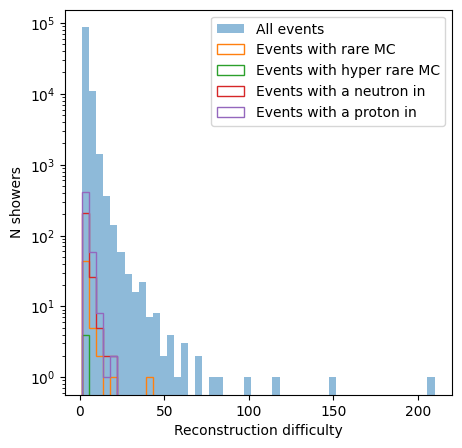

In [20]:
from matplotlib import pyplot as plt
n, bins, patches = plt.hist(scores[:, 1], alpha=0.5, bins=50, label="All events")
plt.hist(rare_scores, bins=bins, label="Events with rare MC", histtype="step")
plt.hist(hyper_rare_scores, bins=bins, label="Events with hyper rare MC", histtype="step")
plt.hist(n_scores, bins=bins, label="Events with a neutron in", histtype="step")
plt.hist(p_scores, bins=bins, label="Events with a proton in", histtype="step")
plt.legend()
plt.semilogy()
plt.xlabel("Reconstruction difficulty")
plt.ylabel("N showers")

In [21]:
[i in indices for i in high_anomaly]

[False, False, False, False, False, False, False, False, False, True]

In [22]:
len(scores)


100000

In [23]:
high_anomaly

array([62490, 47947, 18781, 91198, 74693, 12174, 25107, 90300, 23331,
        1283])